In [15]:
!pip install conllu

In [16]:
import conllu
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import warnings


# Read the data and parse it
with open('en_atis-ud-train.conllu', 'r', encoding="utf-8") as file:
    sentences = conllu.parse(file.read())

    train_data = []
    word_to_idx = {}
    tag_to_idx = {}

    for sentence in sentences:
        words = []
        pos = []
        for i in range(len(sentence)):

            # Extracting word, POS tags, and creating mappings
            word = sentence[i]['form']
            tag = sentence[i]['upos']
            if word not in word_to_idx:
                word_to_idx[word] = len(word_to_idx)
            if tag not in tag_to_idx:
                tag_to_idx[tag] = len(tag_to_idx)

            # Appending word index and POS tag index to lists
            words.append(word)
            pos.append(tag)

        # Appending the tagged sentence to the training data
        tagged_sentence = (words, pos)
        train_data.append(tagged_sentence)



# Define the LSTMTagger class
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, num_layers=1, bidirectional=False, activation=None):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
        self.hidden2tag = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, tagset_size)
        self.activation = activation

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        if self.activation:
            lstm_out = self.activation(lstm_out)  # Apply activation function
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [19]:
# Function to convert sentence to input sequence
def input_seq(sentence, word_to_idx):
    idxs = [word_to_idx.get(w, 0) for w in sentence]
    return torch.tensor(idxs, dtype=torch.long)

# Function to calculate accuracy
def calculate_accuracy(model, data, word_to_idx, tag_to_idx):
    correct_counts = 0
    total_counts = 0
    for sentence, tags in data:
        input_sentence = input_seq(sentence, word_to_idx)
        targets = input_seq(tags, tag_to_idx)
        tag_scores = model(input_sentence)
        predicted_indices = torch.argmax(tag_scores, dim=1)
        correct_counts += torch.sum(predicted_indices == targets).item()
        total_counts += len(targets)
    return correct_counts / total_counts

# Define model parameters and initialize the model
embedding_dim = 128
hidden_dim = 128
vocab_size = len(word_to_idx)
tagset_size = len(tag_to_idx)
# print(vocab_size)
# print(tagset_size)
model = LSTMTagger(embedding_dim, hidden_dim, vocab_size, tagset_size)

# Defining the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training using number of epochs
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for sentence, tags in train_data:
        model.zero_grad()
        input_sentence = input_seq(sentence, word_to_idx)
        targets = input_seq(tags, tag_to_idx)
        tag_scores = model(input_sentence)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    train_accuracy = calculate_accuracy(model, train_data, word_to_idx, tag_to_idx)
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Accuracy: {train_accuracy}")


#Saving the model
torch.save(model.state_dict(), "model.pt")

Epoch: 1, Loss: 0.04607856273651123, Accuracy: 0.8198129688623985
Epoch: 2, Loss: 0.011095333844423294, Accuracy: 0.8883773507347652
Epoch: 3, Loss: 0.005214477889239788, Accuracy: 0.9183434384955298
Epoch: 4, Loss: 0.0031894270796328783, Accuracy: 0.9329770835474257
Epoch: 5, Loss: 0.0022505230735987425, Accuracy: 0.9416298427705272
Epoch: 6, Loss: 0.0017266999930143356, Accuracy: 0.9460487103072655
Epoch: 7, Loss: 0.001393606187775731, Accuracy: 0.9499743089096702
Epoch: 8, Loss: 0.0011627115309238434, Accuracy: 0.9524201007090741
Epoch: 9, Loss: 0.0009932059329003096, Accuracy: 0.9544959408077279
Epoch: 10, Loss: 0.0008636516286060214, Accuracy: 0.9563868050560066
Epoch: 11, Loss: 0.0007616828661412001, Accuracy: 0.9579899290925907
Epoch: 12, Loss: 0.0006798893446102738, Accuracy: 0.9595313945123831
Epoch: 13, Loss: 0.0006129812682047486, Accuracy: 0.9610728599321755
Epoch: 14, Loss: 0.0005572876543737948, Accuracy: 0.9621621621621622
Epoch: 15, Loss: 0.0005101175047457218, Accuracy

In [20]:
# Loading the model
# torch.load("model.pt")
# model.eval()

# Read the dev data and parse it
with open('en_atis-ud-dev.conllu', 'r', encoding="utf-8") as file:
    dev_sentences = conllu.parse(file.read())

    dev_data = []
    for sentence in dev_sentences:
        words = []
        pos = []
        for i in range(len(sentence)):
            word = sentence[i]['form']
            tag = sentence[i]['upos']
            words.append(word)
            pos.append(tag)
        dev_data.append((words, pos))

# Testing the accuracy on the dev set
dev_accuracy = calculate_accuracy(model, dev_data, word_to_idx, tag_to_idx)
print(f"Dev Accuracy: {dev_accuracy}")



# Test dataset reading and parsing it
with open('en_atis-ud-test.conllu', 'r', encoding="utf-8") as file:
    test_sentences = conllu.parse(file.read())

    test_data = []
    for sentence in test_sentences:
        words = []
        pos = []
        for i in range(len(sentence)):
            word = sentence[i]['form']
            tag = sentence[i]['upos']
            words.append(word)
            pos.append(tag)
        test_data.append((words, pos))

# Testing the accuracy on the test set
test_accuracy = calculate_accuracy(model, test_data, word_to_idx, tag_to_idx)
print(f"Test Accuracy: {test_accuracy}")

Dev Accuracy: 0.9525888019265503
Test Accuracy: 0.955775075987842


In [22]:
num_epochs = 5
# Define hyperparameter configurations to experiment with
configurations = [
    {"num_layers": 1, "bidirectional": False, "hidden_size": 256, "embedding_size": 128, "activation": F.relu},
    {"num_layers": 2, "bidirectional": True, "hidden_size": 128, "embedding_size": 256, "activation": F.relu},
    {"num_layers": 1, "bidirectional": False, "hidden_size": 64, "embedding_size": 64, "activation": F.tanh},
]

# Training and evaluating each configuration
#dev_accuracies = []
dev_accuracies = []
test_accuracies = []

for config in configurations:
    print("Training with configuration:")
    print(f"Number of Layers: {config['num_layers']}, Bidirectional: {config['bidirectional']}, Hidden Layer Size: {config['hidden_size']}, Embedding Size: {config['embedding_size']}, Activation Function: {config['activation'].__name__}")
    model = LSTMTagger(embedding_dim=config['embedding_size'], hidden_dim=config['hidden_size'],
                       vocab_size=vocab_size, tagset_size=tagset_size,
                       num_layers=config['num_layers'], bidirectional=config['bidirectional'],
                       activation=config['activation'])

    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for sentence, tags in train_data:
            model.zero_grad()
            input_sentence = input_seq(sentence, word_to_idx)
            targets = input_seq(tags, tag_to_idx)
            tag_scores = model(input_sentence)
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()

    # Evaluation done on dev set
    dev_accuracy = calculate_accuracy(model, dev_data, word_to_idx, tag_to_idx)
    print(f"Dev Accuracy: {dev_accuracy}\n")
    dev_accuracies.append(dev_accuracy)

# Selecting the best performing configuration on the development set
best_config_index = dev_accuracies.index(max(dev_accuracies))
best_config = configurations[best_config_index]
print(f"Best performing configuration on dev set:")
print(f"Number of Layers: {best_config['num_layers']}, Bidirectional: {best_config['bidirectional']}, Hidden Layer Size: {best_config['hidden_size']}, Embedding Size: {best_config['embedding_size']}, Activation Function: {best_config['activation'].__name__}")



# Evaluating the best configuration on the test set
best_model = LSTMTagger(embedding_dim=best_config['embedding_size'], hidden_dim=best_config['hidden_size'],
                        vocab_size=vocab_size, tagset_size=tagset_size,
                        num_layers=best_config['num_layers'], bidirectional=best_config['bidirectional'],
                        activation=best_config['activation'])

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the best model on the entire training set before testing
for epoch in tqdm(range(num_epochs)):
    best_model.train()
    for sentence, tags in train_data:
        best_model.zero_grad()
        input_sentence = input_seq(sentence, word_to_idx)
        targets = input_seq(tags, tag_to_idx)
        tag_scores = best_model(input_sentence)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# Testing the best model on the test set
test_accuracy = calculate_accuracy(best_model, test_data, word_to_idx, tag_to_idx)
print(f"Test Accuracy for the best configuration: {test_accuracy}")


Training with configuration:
Number of Layers: 1, Bidirectional: False, Hidden Layer Size: 256, Embedding Size: 128, Activation Function: relu


100%|██████████| 5/5 [01:35<00:00, 19.18s/it]


Dev Accuracy: 0.9230885009030705

Training with configuration:
Number of Layers: 2, Bidirectional: True, Hidden Layer Size: 128, Embedding Size: 256, Activation Function: relu


100%|██████████| 5/5 [03:08<00:00, 37.76s/it]


Dev Accuracy: 0.9388922335942204

Training with configuration:
Number of Layers: 1, Bidirectional: False, Hidden Layer Size: 64, Embedding Size: 64, Activation Function: tanh


100%|██████████| 5/5 [00:35<00:00,  7.19s/it]


Dev Accuracy: 0.9104455147501506

Best performing configuration on dev set:
Number of Layers: 2, Bidirectional: True, Hidden Layer Size: 128, Embedding Size: 256, Activation Function: relu


100%|██████████| 5/5 [02:55<00:00, 35.08s/it]


Test Accuracy for the best configuration: 0.04939209726443769


100%|██████████| 10/10 [01:22<00:00,  8.25s/it]


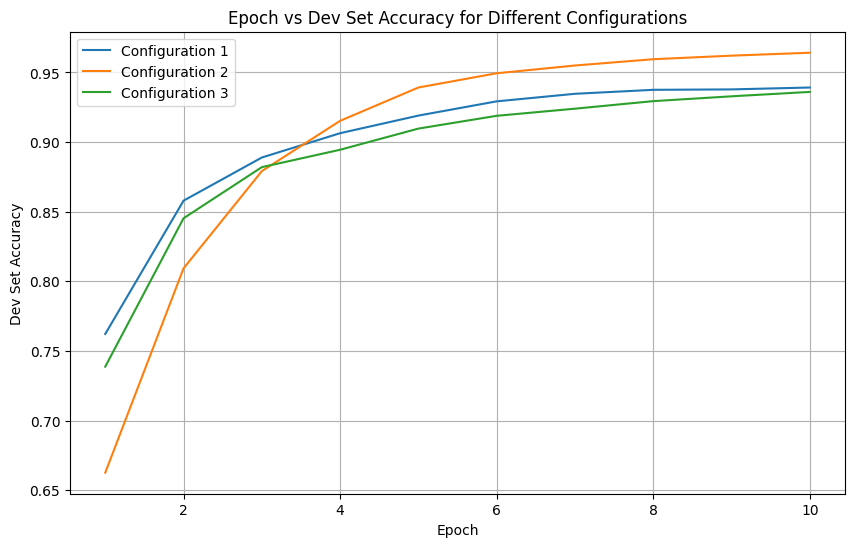

In [24]:
num_epochs = 10
# Define hyperparameter configurations to experiment with
configurations = [
    {"num_layers": 1, "bidirectional": False, "hidden_size": 256, "embedding_size": 128, "activation": F.relu},
    {"num_layers": 2, "bidirectional": True, "hidden_size": 128, "embedding_size": 256, "activation": F.relu},
    {"num_layers": 1, "bidirectional": False, "hidden_size": 64, "embedding_size": 64, "activation": F.tanh},
]

# Training and evaluation of each configuration
dev_accuracies = [[] for _ in range(len(configurations))]
test_accuracies = []

for config_index, config in enumerate(configurations):
    #print("Training with configuration:")
    #print(f"Number of Layers: {config['num_layers']}, Bidirectional: {config['bidirectional']}, Hidden Layer Size: {config['hidden_size']}, Embedding Size: {config['embedding_size']}, Activation Function: {config['activation'].__name__}")
    model = LSTMTagger(embedding_dim=config['embedding_size'], hidden_dim=config['hidden_size'],
                       vocab_size=vocab_size, tagset_size=tagset_size,
                       num_layers=config['num_layers'], bidirectional=config['bidirectional'],
                       activation=config['activation'])

    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Training loop
    dev_accuracy_per_epoch = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for sentence, tags in train_data:
            model.zero_grad()
            input_sentence = input_seq(sentence, word_to_idx)
            targets = input_seq(tags, tag_to_idx)
            tag_scores = model(input_sentence)
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()

        # Evaluating on dev set after each epoch
        dev_accuracy = calculate_accuracy(model, dev_data, word_to_idx, tag_to_idx)
        dev_accuracy_per_epoch.append(dev_accuracy)
        #print(f"Epoch {epoch + 1}, Dev Accuracy: {dev_accuracy}")

    dev_accuracies[config_index] = dev_accuracy_per_epoch

# Plotting epoch vs. dev set accuracy
plt.figure(figsize=(10, 6))
for i, dev_acc_per_epoch in enumerate(dev_accuracies):
    config = configurations[i]
    plt.plot(range(1, num_epochs + 1), dev_acc_per_epoch, label=f"Configuration {i+1}")

plt.xlabel('Epoch')
plt.ylabel('Dev Set Accuracy')
plt.title('Epoch vs Dev Set Accuracy for Different Configurations')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Function for precision, recall, and F1 score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall_micro, recall_macro, precision_micro, precision_macro, f1_micro, f1_macro

# Function for generation of confusion matrix
def generate_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return cm

# Function for model using different metrics
def evaluate_model(model, data, word_to_idx, tag_to_idx):
    true_labels = []
    pred_labels = []
    for sentence, tags in data:
        input_sentence = input_seq(sentence, word_to_idx)
        targets = input_seq(tags, tag_to_idx)
        tag_scores = model(input_sentence)
        predicted_indices = torch.argmax(tag_scores, dim=1)
        true_labels.extend(targets.tolist())
        pred_labels.extend(predicted_indices.tolist())

    # Calculating metrics
    accuracy, recall_micro, recall_macro, precision_micro, precision_macro, f1_micro, f1_macro = calculate_metrics(true_labels, pred_labels)

    # Generating confusion matrix
    labels = list(tag_to_idx.values())
    cm = generate_confusion_matrix(true_labels, pred_labels, labels)

    return accuracy, recall_micro, recall_macro, precision_micro, precision_macro, f1_micro, f1_macro, cm

# Model on dev set
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    dev_accuracy, dev_recall_micro, dev_recall_macro, dev_precision_micro, dev_precision_macro, dev_f1_micro, dev_f1_macro, dev_conf_matrix = evaluate_model(model, dev_data, word_to_idx, tag_to_idx)
print("Evaluation Metrics on Dev Set:")
print(f"Accuracy: {dev_accuracy}")
print(f"Micro Recall: {dev_recall_micro}, Macro Recall: {dev_recall_macro}")
print(f"Micro Precision: {dev_precision_micro}, Macro Precision: {dev_precision_macro}")
print(f"Micro F1 Score: {dev_f1_micro}, Macro F1 Score: {dev_f1_macro}")
print("\nConfusion Matrix:")
print(dev_conf_matrix)

# Model on test set
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    test_accuracy, test_recall_micro, test_recall_macro, test_precision_micro, test_precision_macro, test_f1_micro, test_f1_macro, test_conf_matrix = evaluate_model(model, test_data, word_to_idx, tag_to_idx)
print("\nEvaluation Metrics on Test Set:")
print(f"Accuracy: {test_accuracy}")
print(f"Micro Recall: {test_recall_micro}, Macro Recall: {test_recall_macro}")
print(f"Micro Precision: {test_precision_micro}, Macro Precision: {test_precision_macro}")
print(f"Micro F1 Score: {test_f1_micro}, Macro F1 Score: {test_f1_macro}")
print("\nConfusion Matrix:")
print(test_conf_matrix)


Evaluation Metrics on Dev Set:
Accuracy: 0.9360325105358218
Micro Recall: 0.9360325105358218, Macro Recall: 0.8616604521543635
Micro Precision: 0.9360325105358218, Macro Precision: 0.9356413513144312
Micro F1 Score: 0.9360325105358218, Macro F1 Score: 0.8914983182210985

Confusion Matrix:
[[ 313    1  100    0    0    0    1    0    1    0    0    0    0]
 [   0  243    0    2    0    2   18    0    1    0    0    0    0]
 [   1    1  549    1   11    4    1    0    0    0    0    0    0]
 [   1    1    6 1101    1   19    7    0    7    0    0    0    0]
 [   1    0    0    4 1397    3    1    2    1    0    0    6    0]
 [   0    0    5   12    0 1531    2    0    1    0    0    0    0]
 [   1    2    4    7   66    4  568    0    1    0    0    0    0]
 [   1    0   11    4    1   10    1   98    5    0    0    0    0]
 [   0    0    1   19    0    4    4    1  193    0    5    0    0]
 [   0    0    0    0    0    1    0    0    0  106    0    0    0]
 [   0    0    2   10    0    

In [26]:
def predict_pos_tags(model, sentence, word_to_idx, tag_to_idx):
    # Tokenization
    words = sentence.split()

    # Sentences to input sequence
    input_sentence = input_seq(words, word_to_idx)

    # Pedictions from the model
    tag_scores = model(input_sentence)

    # Get predicted indices
    predicted_indices = torch.argmax(tag_scores, dim=1)

    # Mapping predicted indices to POS tags
    predicted_tags = [list(tag_to_idx.keys())[idx] for idx in predicted_indices]

    return predicted_tags

# One examplke
input_sentence = "I have a book"
predicted_tags = predict_pos_tags(model, input_sentence, word_to_idx, tag_to_idx)
print(input_sentence.split())
print(predicted_tags)

# torch.save(word_to_idx,"word_to_idx.pt")
# print(word_to_idx)

#torch.save(tag_to_idx,"tag_to_idx.pt")

['I', 'have', 'a', 'book']
['DET', 'VERB', 'DET', 'NOUN']
